In [2]:
%matplotlib inline
%load_ext rpy2.ipython
# Loading matplot Python library
# Loading the Rmagic extension

In [3]:
%%R
# loading R packages
library(phyloseq)
library(plyr)
library(dplyr)
#dplyr needs to come in after plyr
library(ggplot2)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [4]:
%%R
physeq = import_biom("OTU_table.biom", parseFunction = parse_taxonomy_greengenes)
# Importing the biom file as a phyloseq object, parsing its taxonomy as greengenes format
sam.data <- read.csv(file="sample.data.csv", row.names=1, header=TRUE)
sample_data(physeq) <- sam.data
physeq = transform_sample_counts(physeq, function(x) x/sum(x))
physeq

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 51928 taxa and 52 samples ]
sample_data() Sample Data:       [ 52 samples by 4 sample variables ]
tax_table()   Taxonomy Table:    [ 51928 taxa by 8 taxonomic ranks ]


In [31]:
%%R
head(colSums(otu_table(physeq)))
# Checking that the counts do add up to 1 - relative abundances

C178N1 C178P1 C185P2 C206N2 C206P1 C206P2 
     1      1      1      1      1      1 


In [10]:
%%R
mdf = psmelt(physeq)
#"melting" the phyloseq data into a dataframe

# We want to calculate the total relative abundance of each phylum
# and then take the top X most abundant phyla

SortedPhyla = mdf %>%
    group_by(Sample,Phylum) %>%
    summarize(PhyAbund = sum(Abundance))%>%
# Should give us the relative abundance of all OTUs in each phylum from each sample.
    group_by(Phylum)%>%
    summarize(MeanPhyAbund = mean(PhyAbund))%>%
    arrange(-MeanPhyAbund)
# Then sums the mean relative abundance of each phylum, across samples, and reports it from most to least

In [27]:
%%R

nPhyla = 13
# How many phyla do we want to include (plus 1 for NAs)?
PhylumList = SortedPhyla[1:nPhyla,1]
PhylumList = PhylumList[is.na(PhylumList)==FALSE,]
PhylumList = levels(droplevels(as.factor(PhylumList$Phylum)))
# List of nPhyla top most abundant phyla
PhylumList

 [1] "[Thermi]"         "Acidobacteria"    "Actinobacteria"   "Armatimonadetes" 
 [5] "Bacteroidetes"    "Cyanobacteria"    "Gemmatimonadetes" "GN02"            
 [9] "Planctomycetes"   "Proteobacteria"   "SR1"              "Verrucomicrobia" 


In [28]:
%%R
physeq2 = subset_taxa(physeq, Phylum %in% PhylumList)
mdf2 = psmelt(physeq2)
head(mdf2)

                        OTU Sample  Abundance TreatmentGroup SampleSite Date
2001304 New.ReferenceOTU480 C172P3 0.23446851          Early      Point J172
231068      HQ178949.1.1333 C206N3 0.19772666           Late      North J206
2001323 New.ReferenceOTU480 C172P1 0.10904945          Early      Point J172
2001297 New.ReferenceOTU480 C172P2 0.10754887          Early      Point J172
2001295 New.ReferenceOTU480 C199N2 0.09467971           Late      North J199
2001300 New.ReferenceOTU480 C206N2 0.09177057           Late      North J206
                              Description  Kingdom         Phylum
2001304 Sample of day 172 at site Point 3 Bacteria  Cyanobacteria
231068  Sample of day 206 at site North 3 Bacteria Proteobacteria
2001323 Sample of day 172 at site Point 1 Bacteria  Cyanobacteria
2001297 Sample of day 172 at site Point 2 Bacteria  Cyanobacteria
2001295 Sample of day 199 at site North 2 Bacteria  Cyanobacteria
2001300 Sample of day 206 at site North 2 Bacteria  Cyanobacteria

In [33]:
%%R
mdf2 = mdf2 %>%
    group_by(Sample,SampleSite,Date,Phylum) %>%
    summarize(PhyAbund = sum(Abundance))

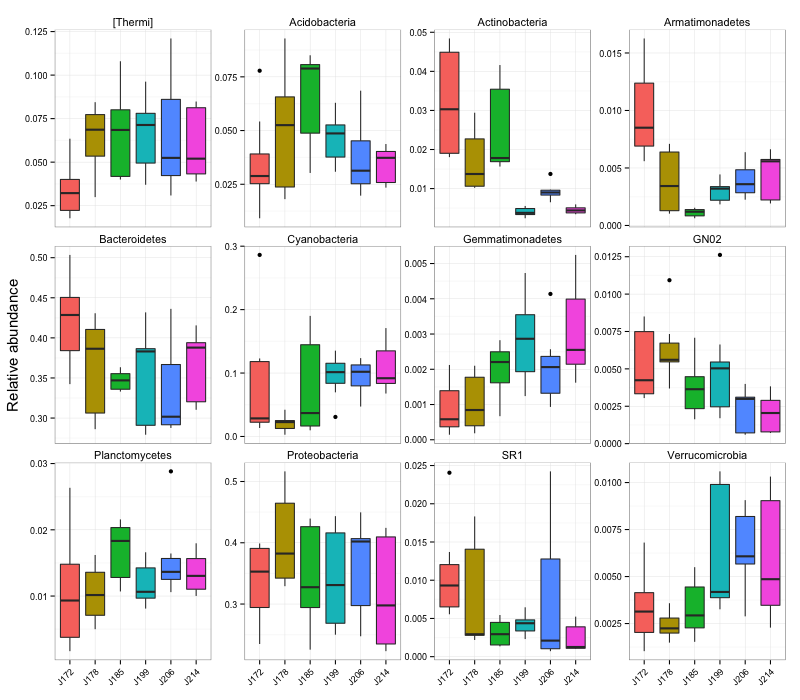

In [43]:
%%R -w 800 -h 700

p = ggplot(mdf2, aes(Date, PhyAbund, fill = Date))

p = p + geom_boxplot()

p = p + facet_wrap(~Phylum, scales = "free_y")

#p = p + scale_fill_manual(values=c("orange","gold1","red3"))

p = p + theme_bw()

p = p + guides(fill = "none")
p = p + theme(legend.position = "none")

p = p + theme(strip.text.x = element_text(size=11), 
              strip.text.y = element_text(size=9), 
                strip.background = element_rect(colour="white", fill="white"))

p = p + theme(axis.text.x = element_text(size = 9, angle = 45, hjust=1),axis.text.y = element_text(size = 9))
p = p + theme(axis.title.x = element_blank())
p = p + theme(axis.title.y = element_text(size = 15, vjust = 1))

p = p + labs(x="Amendment",y="Relative abundance")

p